# Gradient Obfuscation and Adaptive Attacks

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/unica-mlsec/mlsec/blob/HEAD/labs/05_gradient_obfuscation_and_adaptive_attacks.ipynb)

In this tutorial, we are going to test the robustness of two defenses that were specifically designed to be strong against gradient-based attacks.

Despite the efforts, however, these models were later shown to be just *hiding* the adversarial examples rather than removing them. They were broken by **adaptive** attacks, *i.e.*, attacks that target the specific defense mechanism that is in place.

In [1]:
try:
    import secml
except ImportError:
    %pip install git+https://github.com/pralab/secml

try:
    import foolbox
except ImportError:
    %pip install foolbox

try:
    import robustbench
except ImportError:
    %pip install git+https://github.com/RobustBench/robustbench.git

import os
if not os.path.exists("models"):
    !git clone https://github.com/unica-mlsec/mlsec.git
    os.chdir("mlsec/labs")

## The k-Winners-Take-All (k-WTA) Defense

This defense was proposed in [1]. This defense replaces the usual activation layer of the DNNs (ReLU) with a k-WTA activation function.

As shown in the picture, the ReLU sets to zero the neurons that have a negative output, whereas the k-WTA sets to zero all weights except the top-k (optionally in absolute value, there are different possible configurations).

![](assets/kWTA.png)

This trick aims to break gradient descent by introducing $C_0$ discontinuities on the loss landscape. In this way, any gradient-based attack would fail in finding a consistent direction to minimize the loss.

[1] Xiao, Chang, Peilin Zhong, and Changxi Zheng. "Enhancing Adversarial Defense by k-Winners-Take-All." International Conference on Learning Representations. 2019.


In [2]:
import os
import torch
from robustbench.utils import download_gdrive
from secml.array import CArray
from secml.ml import CClassifierPyTorch
from models.kwta import SparseResNet18

if not os.path.exists("pretrained"):
    os.mkdir("pretrained")

# key of a Google Drive file containing the pretrained model
MODEL_ID = '1Af_owmMvg1LxjITLE1gFUmPx5idogeTP'

gamma = 0.1  # sparsity ratio
filepath = os.path.join('pretrained', f'kwta_spresnet18_{gamma}_cifar_adv.pth')
if not os.path.exists(filepath):
    # utility function to handle google drive data
    download_gdrive(MODEL_ID, filepath)

# check out the model class in the imported module to see the implementation
# of this defense
model = SparseResNet18(sparsities=[gamma, gamma, gamma, gamma])

# check if CUDA is available
if not torch.cuda.is_available():
    state_dict = torch.load(filepath, map_location='cpu')
else:
    state_dict = torch.load(filepath)

# load model and wrap it in secml classifier class
model.load_state_dict(state_dict)
model.eval()
clf = CClassifierPyTorch(model, input_shape=(3, 32, 32), pretrained=True,
                         pretrained_classes=CArray(list(range(10))), preprocess=None)

Download started: path=pretrained/kwta_spresnet18_0.1_cifar_adv.pth (gdrive_id=1Af_owmMvg1LxjITLE1gFUmPx5idogeTP)
Download finished: path=pretrained/kwta_spresnet18_0.1_cifar_adv.pth (gdrive_id=1Af_owmMvg1LxjITLE1gFUmPx5idogeTP)


In [3]:
# load CIFAR10 dataset (we only need the test set)
from secml.data.loader import CDataLoaderCIFAR10
_, ts = CDataLoaderCIFAR10().load()

# let's use a subset of the data
ts = ts[:100, :]

# transform data to stay in [0, 1] bounds
ts.X /= 255

In [4]:
# check model accuracy on the CIFAR10 data
from secml.ml.peval.metrics import CMetricAccuracy

metric = CMetricAccuracy()
preds = clf.predict(ts.X)

acc = metric.performance_score(y_true=ts.Y, y_pred=preds)
print(f"Model accuracy: {acc*100} %")

Model accuracy: 70.0 %


## Exercise
Attack the model with untargeted PGD $\ell_\infty$, $\varepsilon=0.03$, $\alpha=0.005$ and 30 steps.
Apply it to the first 10 samples of the test set.

In [6]:
idx = 10
samples, labels = ts.X[:idx, :], ts.Y[:idx]
y_pred = clf.predict(samples)

from secml.adv.attacks import CFoolboxPGDLinf

epsilon = 0.03
abs_stepsize = 0.005
steps = 30
random_start = False

attack = CFoolboxPGDLinf(classifier=clf, 
                        epsilons=epsilon,
                        abs_stepsize=abs_stepsize,
                        steps=steps,
                        random_start=False)


# we only need the predictions to compute the robust accuracy
y_pred_adv, _, _, _ = attack.run(samples, labels)

accuracy = metric.performance_score(y_true=labels, y_pred=y_pred)
robust_accuracy = metric.performance_score(y_true=labels, y_pred=y_pred_adv)

print(f"Accuracy: {accuracy}")
print(f"Robust accuracy: {robust_accuracy}")

Accuracy: 0.9
Robust accuracy: 0.8


Did it work?
Probably not as expected... But the model is not as robust as it seems.
Let's try to visualize the loss of the attack on one single sample.

True label: CArray([3])
Original pred.: CArray([3])
Adv. pred.: CArray([3])


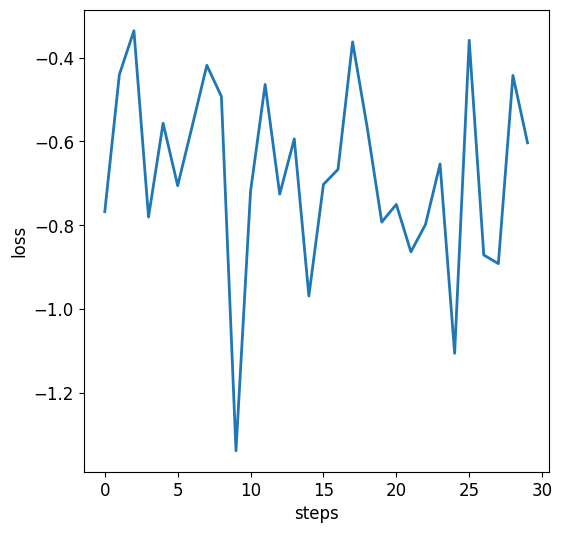

In [8]:
%matplotlib inline
point = 0
x0, y0 = ts.X[point, :], ts.Y[point]
pred = clf.predict(x0)
y_pred_adv, _, _, _ = attack.run(x0, y0)

print(f"True label: {y0}\nOriginal pred.: {pred}\nAdv. pred.: {y_pred_adv}")

from secml.figure import CFigure
fig = CFigure()

# this stores the path of the attack
path = attack.x_seq
fig.sp.plot(attack.objective_function(path))
fig.sp.xlabel("steps")
fig.sp.ylabel("loss")
fig.show()

The attack is not working because the optimization is not really improving the objective.
This is caused by gradient obfuscation.
As explained before, the model is indeed causing the loss landscape to become extremely noisy (this is shown also in the paper).

![](assets/kWTA_landscape.png)

How to fix this? We need an **adaptive attack**[2].

[2] Tramer, Florian, et al. "On adaptive attacks to adversarial example defenses." Advances in Neural Information Processing Systems 33 (2020): 1633-1645.


## Exercise

Open the referenced paper [2] and find the model that we just attacked and read through the section (hint: go to https://arxiv.org and find the paper there).
What causes the model to be strong against gradient-based attacks?
How did the authors of [2] break the defense?


## Adaptive attack for k-WTA

We are now using an implementation of the attack in [2] (adapted for SecML).

The attack estimates the gradient by querying the model (without computing the white-box gradient), and by computing a finite-difference approximation on sets of points sampled in a neighborhood of the sample.
The smoother approximation is then obtained by averaging the direction of all these estimated gradients.

This approximation has a cost: it has to query the model multiple time for each step of the attack, as the gradient has to be estimated locally each time.


In [9]:
from attacks.averaged_pgd import CFoolboxAveragedPGD

# note: it takes longer to run this attack than regular PGD!
smooth_attack = CFoolboxAveragedPGD(classifier=clf, epsilons=epsilon, abs_stepsize=abs_stepsize, steps=steps, random_start=random_start, k=50)

True label: CArray([3])
Original pred.: CArray([3])
Adv. pred.: CArray([2])


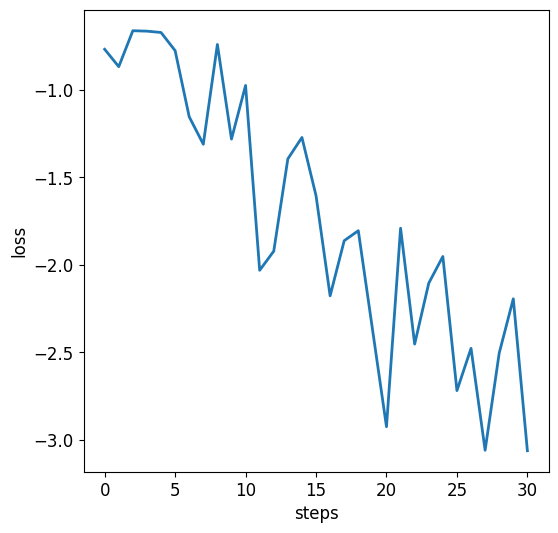

In [10]:
%matplotlib inline
y_pred_adv_smooth, _, _, _ = smooth_attack.run(x0, y0)

print(f"True label: {y0}\nOriginal pred.: {pred}\nAdv. pred.: {y_pred_adv_smooth}")

fig = CFigure()

# this stores the path of the attack
path = smooth_attack.x_seq
fig.sp.plot(smooth_attack.objective_function(path))
fig.sp.xlabel("steps")
fig.sp.ylabel("loss")
fig.show()

Now the loss is smoother. One can potentially make it even smoother by changing one parameter of the attack. Which one?



## Defensive distillation

The defensive distillation method first trains an initial network $f$ on data $x$ with a softmax temperature of $T$. Then it uses the probability vector $f(x)$, which includes additional knowledge about classes compared to a class label, predicted by network $f$, to train a distilled network $f_d$ at temperature $T$ on the same data $x$.

In other words, the network $f_d$ is trained using *soft labels*. In fact, they might not even be correct, but they are representation of what the model $f$ has learnt.

![](assets/distillation.png)

[3] Papernot, Nicolas, et al. "Distillation as a defense to adversarial perturbations against deep neural networks." 2016 IEEE symposium on security and privacy (SP). IEEE, 2016.

The idea behind this defense is that the student network should learn a "hardened" function that is constant around the tested samples.


In [11]:
from models.distillation import MNIST9Layer
import os

import torch
from robustbench.utils import download_gdrive
from secml.array import CArray
from secml.ml import CClassifierPyTorch
from torch import nn

MODEL_ID = '1s7Kfa2Bs5nY2zLd6dVAxUqNbCNQhPYxs'

model = MNIST9Layer()
path = os.path.join('pretrained', 'mnist_distilled.pt')
if not os.path.exists(path):
    download_gdrive(MODEL_ID, path)
state_dict = torch.load(path, map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
model.load_state_dict(state_dict)
model.eval()

clf = CClassifierPyTorch(model, input_shape=(1, 28, 28), pretrained=True,
                         pretrained_classes=CArray(list(range(10))), preprocess=None)


Download started: path=pretrained/mnist_distilled.pt (gdrive_id=1s7Kfa2Bs5nY2zLd6dVAxUqNbCNQhPYxs)
Download finished: path=pretrained/mnist_distilled.pt (gdrive_id=1s7Kfa2Bs5nY2zLd6dVAxUqNbCNQhPYxs)


In [12]:
# load MNIST dataset (we only need the test set)
from secml.data.loader import CDataLoaderMNIST
ts = CDataLoaderMNIST().load('testing')

# let's use a subset of the data
ts = ts[:100, :]

# transform data to stay in [0, 1] bounds
ts.X /= 255

## Exercise

Test the classification accuracy of the distilled network, and attack it again with PGD. Remember that we have to define again the attack for every new classifier. The attack hyperparameters will also be different.
Use the following hyperparameters:
* $\varepsilon=0.3$
* $\alpha=0.05$
* steps = 100

In [13]:
idx = 100
samples, labels = ts.X[:idx, :], ts.Y[:idx]

y_pred = clf.predict(samples)

epsilon = 0.3
abs_stepsize = 0.05
steps = 100
random_start = False

from secml.adv.attacks import CFoolboxPGDLinf
attack = CFoolboxPGDLinf(classifier=clf, 
                        epsilons=epsilon, abs_stepsize=abs_stepsize,
                        steps=steps, random_start=random_start)

from secml.ml.peval.metrics import CMetricAccuracy
metric = CMetricAccuracy()

# we only need the prediction to compute the robust accuracy
y_pred_adv, _, _, _ = attack.run(samples, labels)

accuracy = metric.performance_score(y_true=labels, y_pred=y_pred)
robust_accuracy = metric.performance_score(y_true=labels, y_pred=y_pred_adv)

print(f"Accuracy: {accuracy}")
print(f"Robust accuracy: {robust_accuracy}")

Accuracy: 0.98
Robust accuracy: 0.95


The robust accuracy after the attack is almost the same as the original accuracy.
Let's check again the loss function to understand the problem.


True label: CArray([7])
Original pred.: CArray([7])
Adv. pred.: CArray([7])


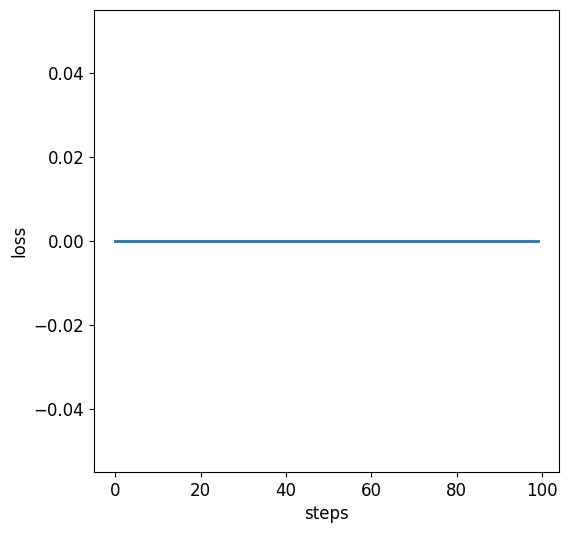

In [14]:
%matplotlib inline
point = 0
x0, y0 = ts.X[point, :], ts.Y[point]
pred = clf.predict(x0)
y_pred_adv, _, _, _ = attack.run(x0, y0)

print(f"True label: {y0}\nOriginal pred.: {pred}\nAdv. pred.: {y_pred_adv}")

from secml.figure import CFigure
fig = CFigure()

# this stores the path of the attack
path = attack.x_seq
fig.sp.plot(attack.objective_function(path))
fig.sp.xlabel("steps")
fig.sp.ylabel("loss")
fig.show()

As the gradient update is defined as:

$x_{i+1} = x_i + \alpha \nabla f(x_i, y, \theta)$,

there might be two possibilities. Either the step size is too small, or the gradient is zero!

If the gradient is zero, the point $x_i$ is never updated!
Let's check the size of the gradient (any norm is fine).

In [15]:
gradient = attack.objective_function_gradient(x0)

gradient_size = gradient.norm()

print("L2 norm of the gradient:", gradient_size)

L2 norm of the gradient: 0.0


The distillation defense leverages a specific trick that makes the softmax function saturate, hence making its computations on the gradient *unstable*.

The softmax function is usually cascaded after DNNs to get outputs that look like probabilities, *i.e.*, to sum up to 1.

This defense can be broken by removing the softmax

True label: CArray([7])
Original pred.: CArray([7])
Adv. pred.: CArray([3])


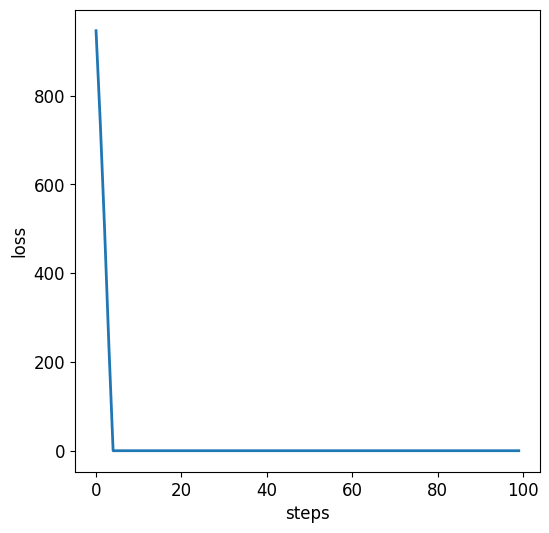

In [16]:
%matplotlib inline

from attacks.logits_pgd import CFoolboxLogitsPGD

logits_attack = CFoolboxLogitsPGD(classifier=clf, epsilons=epsilon, abs_stepsize=abs_stepsize, steps=steps,
                                    random_start=random_start)
y_pred_adv_logits, _, _, _ = logits_attack.run(x0, y0)

print(f"True label: {y0}\nOriginal pred.: {pred}\nAdv. pred.: {y_pred_adv_logits}")

fig = CFigure()

# this stores the path of the attack
path = logits_attack.x_seq
fig.sp.plot(logits_attack.objective_function(path))
fig.sp.xlabel("steps")
fig.sp.ylabel("loss")
fig.show()

## Exercise

Compute the gradient of the new attack function and show its norm.


In [17]:
gradient = logits_attack.objective_function_gradient(x0)

gradient_size = gradient.norm()

print("L2 norm of the gradient:", gradient_size)

L2 norm of the gradient: 264.8598742951041


## Exercise

Another strategy might have worked in this case.
Hint: remember that the distilled network is learning an approximation of the teacher network!

In [18]:
MODEL_ID = '1qmjepc4k_o4BIqCvUJgwg-K19CaovOrQ'

teacher_model = MNIST9Layer()
teacher_path = os.path.join('pretrained', 'mnist_teacher.pt')
if not os.path.exists(teacher_path):
    download_gdrive(MODEL_ID, teacher_path)
teacher_state_dict = torch.load(teacher_path, map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
teacher_model.load_state_dict(teacher_state_dict)
teacher_model.eval()

teacher_clf = CClassifierPyTorch(teacher_model, input_shape=(1, 28, 28), pretrained=True,
                                 pretrained_classes=CArray(list(range(10))), preprocess=None)



idx = 10
samples, labels = ts.X[:idx, :], ts.Y[:idx]

epsilon = 0.3
abs_stepsize = 0.05
steps = 100
random_start = False
attack_teacher = CFoolboxPGDLinf(classifier=teacher_clf,
                                 epsilons=epsilon, abs_stepsize=abs_stepsize,
                                 steps=steps, random_start=random_start)

# we only need the prediction to compute the robust accuracy
y_pred_adv_teacher, _, adv_ds, _ = attack_teacher.run(samples, labels)

y_pred_student = clf.predict(samples)
y_pred_adv_student = clf.predict(adv_ds.X)

accuracy = metric.performance_score(y_true=labels, y_pred=y_pred_student)
robust_accuracy_teacher = metric.performance_score(y_true=labels, y_pred=y_pred_adv_teacher)
robust_accuracy_student = metric.performance_score(y_true=labels, y_pred=y_pred_adv_student)

print(f"Robust accuracy teacher: {robust_accuracy_teacher}")

print(f"Accuracy student: {accuracy}")
print(f"Robust accuracy student: {robust_accuracy_student}")


Download started: path=pretrained/mnist_teacher.pt (gdrive_id=1qmjepc4k_o4BIqCvUJgwg-K19CaovOrQ)
Download finished: path=pretrained/mnist_teacher.pt (gdrive_id=1qmjepc4k_o4BIqCvUJgwg-K19CaovOrQ)
Robust accuracy teacher: 0.0
Accuracy student: 1.0
Robust accuracy student: 0.0


True label: CArray([7])
Original pred.: CArray([7])
Adv. pred.: CArray([8])


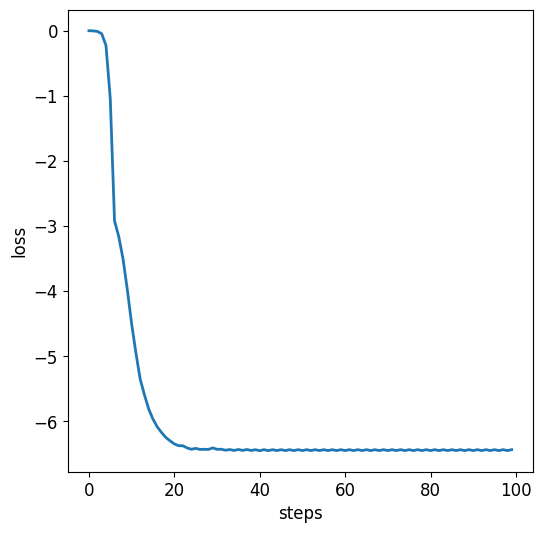

In [19]:
%matplotlib inline

point = 0
x0, y0 = ts.X[point, :], ts.Y[point]
pred = teacher_clf.predict(x0)
y_pred_adv, _, _, _ = attack_teacher.run(x0, y0)

print(f"True label: {y0}\nOriginal pred.: {pred}\nAdv. pred.: {y_pred_adv}")

fig = CFigure()

# this stores the path of the attack
path = attack_teacher.x_seq
fig.sp.plot(attack_teacher.objective_function(path))
fig.sp.xlabel("steps")
fig.sp.ylabel("loss")
fig.show()

